In [1]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/paolo/.conda/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

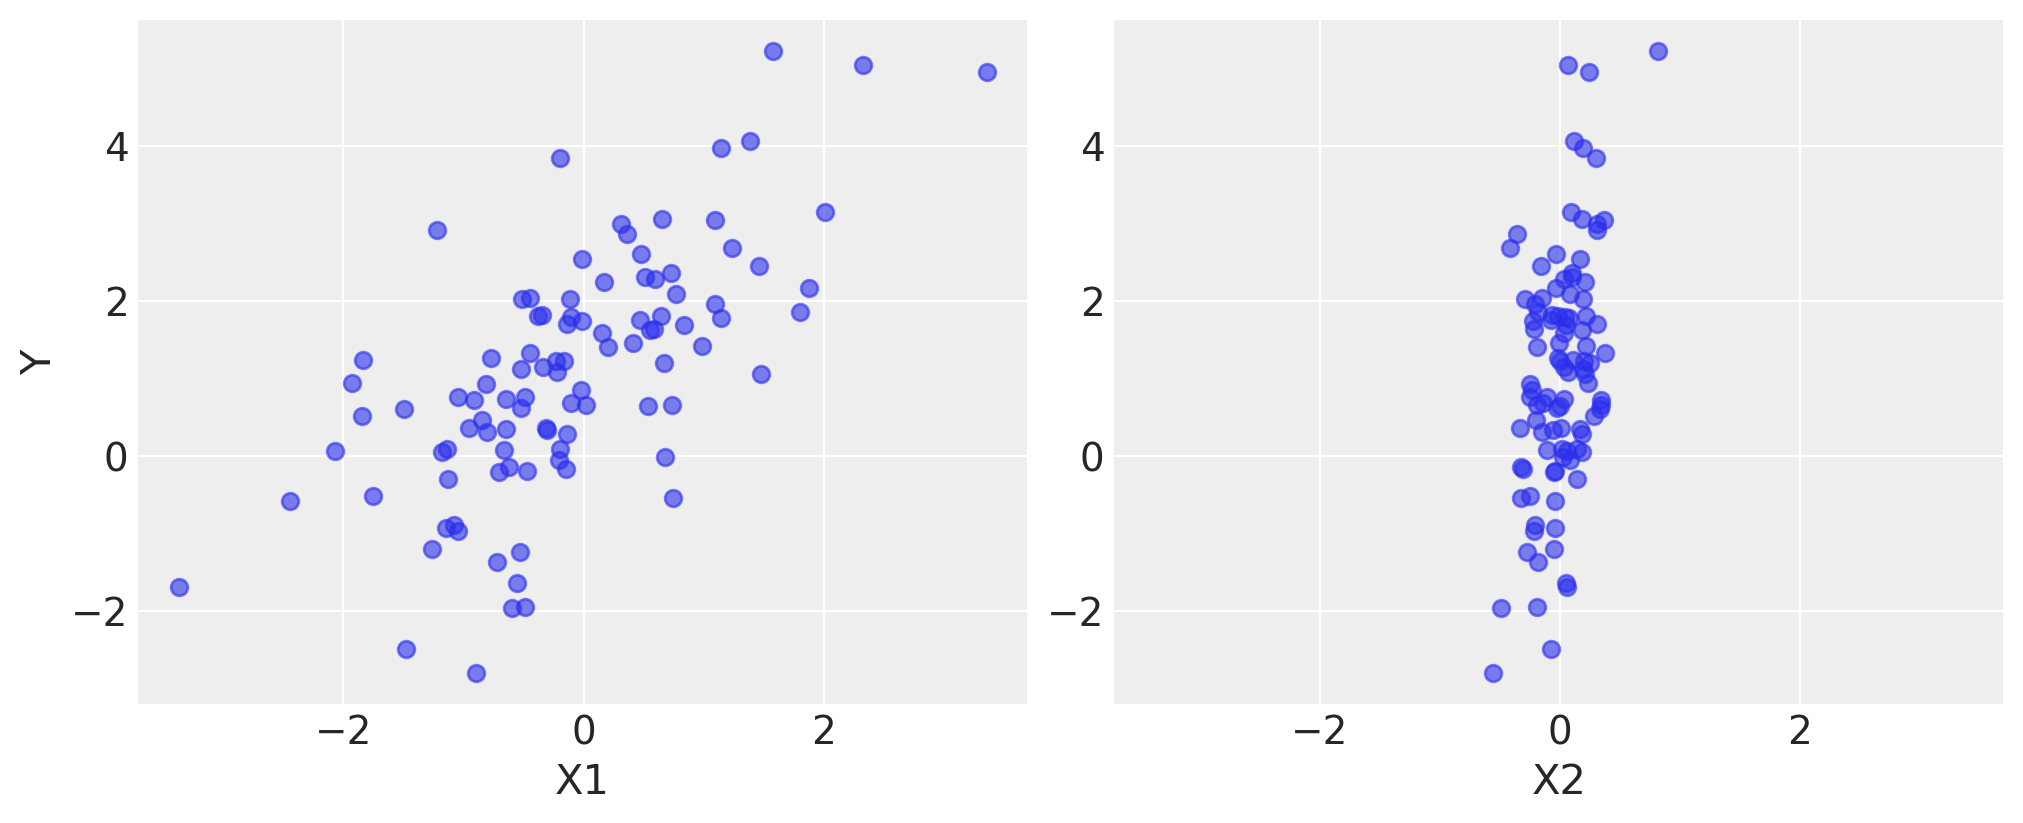

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

Bayesian approach: we treat the model parameters (like slopes and intercepts) as random variables with prior distributions, rather than fixed unknowns and compute a posterior distribution over the possible regression parameters given our data, instead of finding the parameters that best fit the model by minimizing an error function.

In [24]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations --> normal distribution with the deterministic equation as mean and sigma as variance
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

mu = alpha + beta[0]*X1 + beta[1]*X2,

This creates a deterministic random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of Y_obs are not fixed values, but rather are the deterministic object mu and the stochastic sigma. This creates parent-child relationships between the likelihood and these two variables.

The unnormalized posterior is computed in the background by combining prior and likelihood distributions using Bayes' theorem. In many real-world models, the posterior can't be computed analytically (e.g., it doesn’t have a closed-form solution). That’s why we use sampling-based methods (MCMC) to approximate it numerically.

In [16]:
with basic_model:
    # To change the sampling method, NUTS should be the default
    #step = pm.Metropolis()
    # draw 1000 posterior samples from the unnormalized posterior distribution computed as likelihood x prior
    idata = pm.sample()

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             1.32        3            2113.70 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.95        3            1927.81 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             1.08        7            1989.80 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.64        7            1731.39 draws/s   0:00:01   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [7]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

The various attributes of the InferenceData object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. For example, we can retrieve the sampling trace from the alpha latent variable by using the variable name as an index to the idata.posterior attribute. The first dimension of the returned array is the chain index, the second dimension is the sampling index, while the later dimensions match the shape of the variable. We can see the first 5 values for the alpha variable in each chain as follows:

In [21]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.20973589, 0.9903527 , 1.25807283, 1.13478077, 1.18288016],
       [0.97718684, 1.17756302, 1.07855245, 1.07457605, 1.18006847],
       [1.03749721, 1.09050401, 1.11437674, 1.19808682, 1.13001209],
       [1.28955153, 1.23759717, 1.15531426, 1.12726475, 1.11131038]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

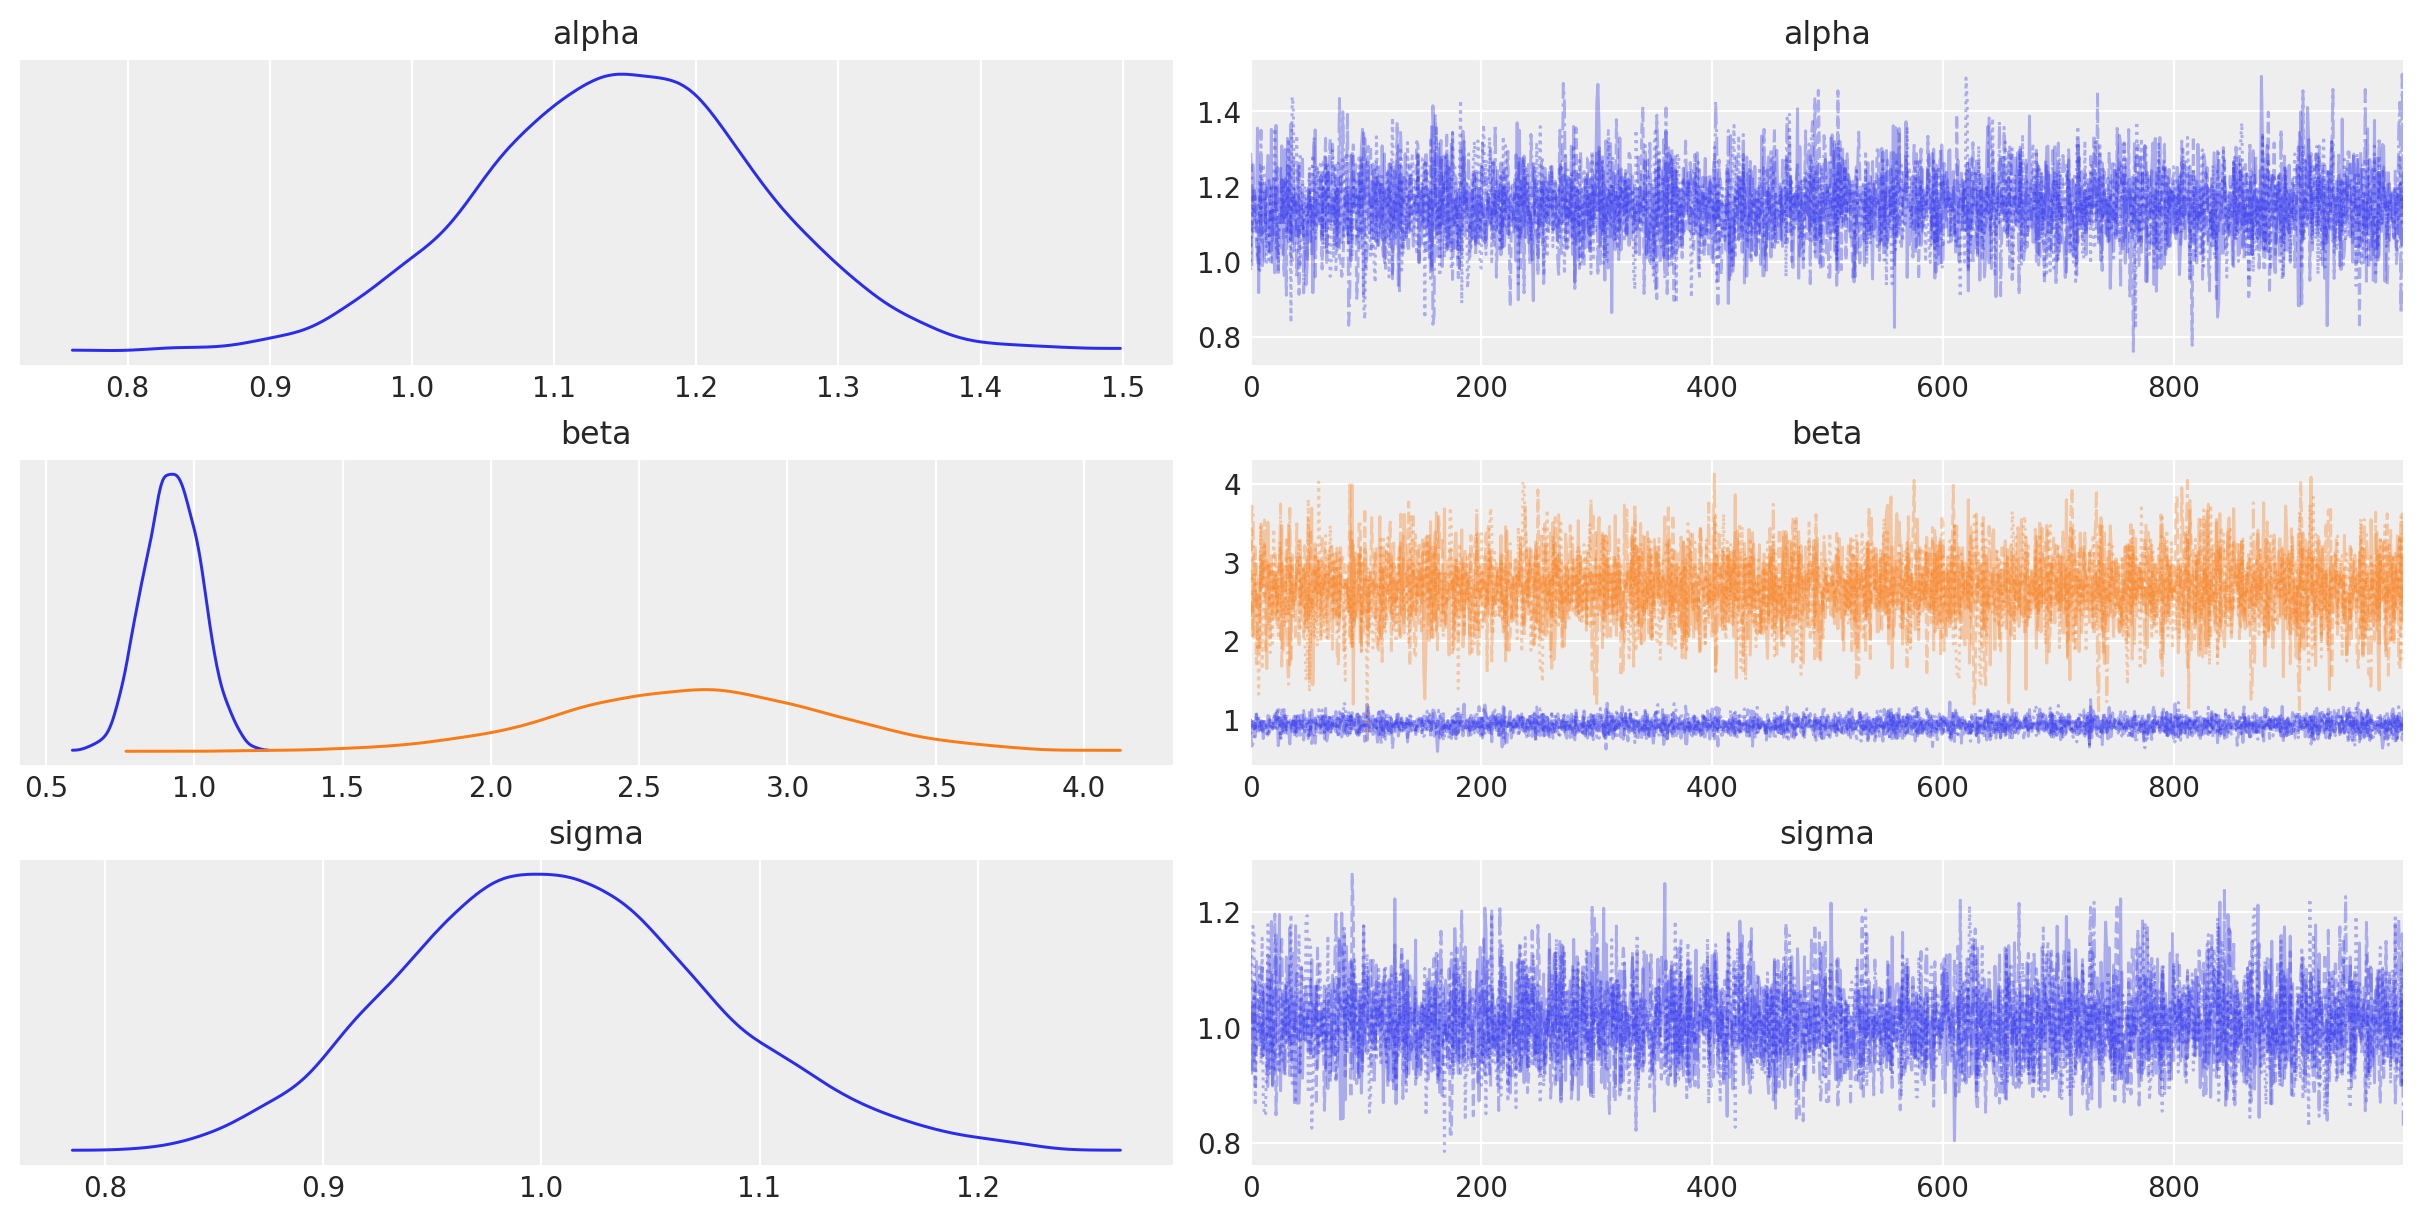

In [22]:
az.plot_trace(idata, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

Gaussian posteriors: expected since both likelihoods and priors were normally distributed.

In addition, the summary function provides a text-based output of common posterior statistics:

In [23]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.10,0.95,1.32,0.00,0.00,5761.77,3194.42,1.0
beta[0],0.93,0.10,0.75,1.11,0.00,0.00,5347.53,3401.06,1.0
beta[1],2.68,0.46,1.79,3.52,0.01,0.01,5612.36,3140.70,1.0
sigma,1.01,0.07,0.87,1.14,0.00,0.00,4955.65,3026.69,1.0
